In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from catboost import CatBoostClassifier

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

plt.style.use('seaborn-v0_8')

Подгружаем эмбеддинги

In [2]:
with open('embeddings_resnet_train.pkl', 'rb') as f:
    dtr_r = pickle.load(f)
with open('embeddings_simplecnn_train.pkl', 'rb') as f:
    dtr_s = pickle.load(f)

X_train_dict = {
    'resnet': np.asarray(dtr_r['X'], dtype=np.float32),
    'simplecnn': np.asarray(dtr_s['X'], dtype=np.float32),
}
y_train_dict = {
    'resnet': np.asarray(dtr_r['y'], dtype=np.int64),
    'simplecnn': np.asarray(dtr_s['y'], dtype=np.int64),
}

print('resnet:', X_train_dict['resnet'].shape, 'simplecnn:', X_train_dict['simplecnn'].shape)

resnet: (10000, 512) simplecnn: (10000, 4096)


Перебираем ключевые гиперпараметры (CatBoost — iterations/depth, RandomForest — n_estimators/max_depth)

In [3]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_space = {
    ('CatBoost', 'iterations'): [50, 100, 150],
    ('CatBoost', 'depth'): [2, 3, 4],
    ('RandomForest', 'n_estimators'): [50, 100, 150, 200],
    ('RandomForest', 'max_depth'): [None, 2, 4, 6],
}

results_rows = []

for emb_name in ['resnet', 'simplecnn']:
    X_full = X_train_dict[emb_name]
    y_full = y_train_dict[emb_name]

    rng = np.random.RandomState(42)
    idx = rng.choice(len(y_full), size=min(500, len(y_full)), replace=False)
    X = X_full[idx]
    y = y_full[idx]

    for (model_name, param_name), values in param_space.items():
        for val in values:
            fold_metrics = []
            for tr_idx, va_idx in skf.split(X, y):
                Xtr, Xva = X[tr_idx], X[va_idx]
                ytr, yva = y[tr_idx], y[va_idx]

                scaler = StandardScaler()
                Xtr_s = scaler.fit_transform(Xtr)
                Xva_s = scaler.transform(Xva)

                if model_name == 'CatBoost':
                    kwargs = dict(
                        iterations=100,
                        learning_rate=0.07,
                        depth=2,
                        loss_function='MultiClass',
                        verbose=0,
                        random_state=42,
                        allow_writing_files=False,
                    )
                    if param_name == 'iterations':
                        kwargs['iterations'] = val
                    if param_name == 'depth':
                        kwargs['depth'] = val
                    model = CatBoostClassifier(**kwargs)
                elif model_name == 'RandomForest':
                    kwargs = dict(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)
                    if param_name == 'n_estimators':
                        kwargs['n_estimators'] = val
                    if param_name == 'max_depth':
                        kwargs['max_depth'] = val
                    model = RandomForestClassifier(**kwargs)
                else:
                    raise ValueError('Unknown model')

                model.fit(Xtr_s, ytr)
                y_pred = model.predict(Xva_s)

                acc = accuracy_score(yva, y_pred)
                p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
                    yva, y_pred, average='macro', zero_division=0
                )
                fold_metrics.append((acc, p_macro, r_macro, f_macro))

            acc_m, p_m, r_m, f_m = np.mean(fold_metrics, axis=0)
            results_rows.append({
                'Model': model_name,
                'Embedding': emb_name,
                'ParamName': param_name,
                'ParamValue': str(val) if val is not None else 'None',
                'accuracy': float(acc_m),
                'precision': float(p_m),
                'recall': float(r_m),
                'f1': float(f_m),
            })

results_df = pd.DataFrame(results_rows)
results_df = results_df.set_index(['Model','Embedding','ParamName','ParamValue']).sort_index()
print(results_df)

                                                accuracy  precision    recall        f1
Model        Embedding ParamName    ParamValue                                         
CatBoost     resnet    depth        2              0.960   0.963535  0.957657  0.958130
                                    3              0.970   0.972923  0.968323  0.968600
                                    4              0.970   0.973298  0.968227  0.968464
                       iterations   100            0.960   0.963535  0.957657  0.958130
                                    150            0.962   0.964836  0.959197  0.959406
                                    50             0.946   0.950252  0.942576  0.943684
             simplecnn depth        2              0.460   0.438223  0.444258  0.416157
                                    3              0.484   0.493054  0.470131  0.454855
                                    4              0.488   0.523932  0.480621  0.472862
                       iteration

Визуализируем зависимость f1 от гиперпараметров

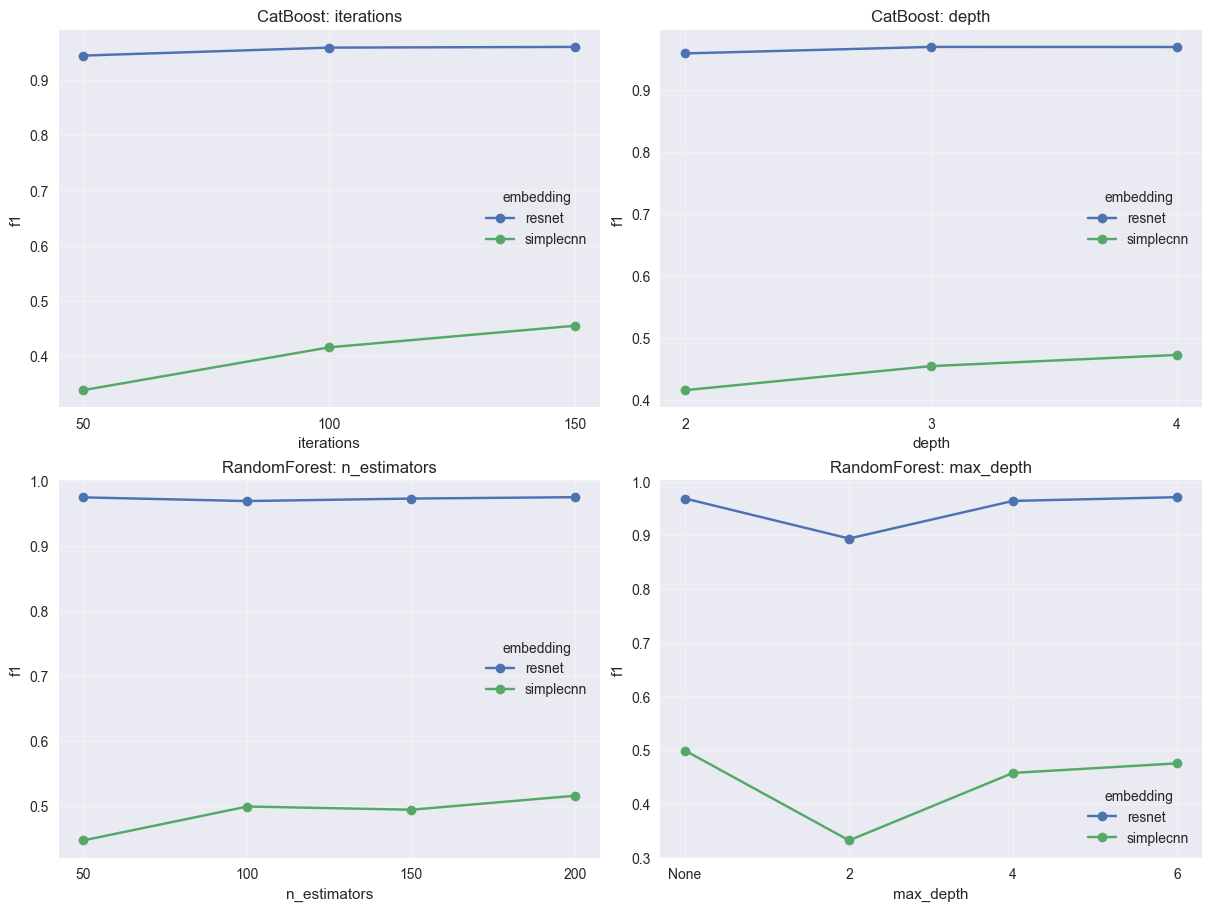

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

pairs = [
    ('CatBoost', 'iterations', axes[0, 0]),
    ('CatBoost', 'depth', axes[0, 1]),
    ('RandomForest', 'n_estimators', axes[1, 0]),
    ('RandomForest', 'max_depth', axes[1, 1]),
]

for model, param, ax in pairs:
    for emb in ['resnet', 'simplecnn']:
        df = results_df.xs((model, emb, param), level=['Model', 'Embedding', 'ParamName'])
        xs_raw = list(df.index)
        if param == 'max_depth':
            order = [v for v in ['None', '2', '4', '6'] if v in xs_raw]
            xs = list(range(len(order)))
            y = df.loc[order]['f1'].values
            ax.plot(xs, y, marker='o', label=emb)
            ax.set_xticks(xs)
            ax.set_xticklabels(order)
        else:
            xs_num = [int(v) for v in xs_raw]
            order_idx = np.argsort(xs_num)
            xs_sorted = [xs_num[i] for i in order_idx]
            y = df['f1'].values[order_idx]
            ax.plot(xs_sorted, y, marker='o', label=emb)
            ax.set_xticks(xs_sorted)
        ax.set_xlabel(param)
        ax.set_ylabel('f1')
        ax.set_title(f'{model}: {param}')
    ax.grid(True, alpha=0.3)
    ax.legend(title='embedding')

plt.show()